# BANDGAP DREAMING EXPERIMENTS

In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
# imports
import sys, os
sys.path.append('../../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, prepare_dreaming_mof, prepare_dreaming_edge, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
from rdkit import Chem
rdkit.RDLogger.DisableLog('rdApp.warning')

### Collect our input data

In [3]:
training_data = pd.read_csv('../../train_models/training_data.csv')
group_grammar = GroupGrammar.from_file('../gs_mof_grammar.txt')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [4]:
target_names = ['bandgap']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

../../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [5]:
train_df.head(1)

,MOFname,edge_group_selfie,node_selfie,topo,bandgap,tokenized_edge_selfies,edge_lens,node_plus_topo,tokenized_node_plus_topo,node_plus_topo_lens,mof_string,tokenized_mof_string,mof_string_lens
0,sxb_N265_edge4527,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,sxb,3.926785,"[16, 68, 61, 52, 60, 61, 60, 65, 52, 60, 64, 7...",31,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,"[34, 22, 48, 65, 48, 22, 20, 22, 34, 48, 65, 2...",56,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,"[20, 110, 75, 58, 74, 75, 74, 101, 58, 74, 89,...",89


# Load Language Models

In [6]:
dream_name = f'LSTM_interval_noise_06_{target_names[0]}_11000samples_group_selfies'
predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'

with open('../..//train_models/mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

with open('../../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

## Test model

(1000, 1)


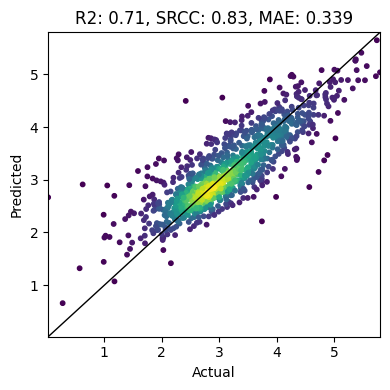

In [8]:
validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=predictor_scaler,noise_level=predictor_train_info['noise_level'])
create_parity_plot(predictor_model, predictor_scaler, validate_loader)

# Dreaming 

#### Shited property distributions

In [ ]:
# ******************* EXAMPLE CELL TO OPTIMISE DISTRIBUTION *******************

# Seed distribution
seed = pd.read_csv(('../seeds/bandgap_1000_seed_df.csv'))
target_values = [0]     # min(bandgap)

# Dream settings
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }

# Perform dreaming for a distribution of cp MOFs
dream_results = []
exceptions = []
start, stop = 0, 10
count = 0
for i in range(start,stop): 
    print(i)
    try:
        global_opt_pathways = []
        for j in range(10): 
            seed_mof_string = seed.iloc[i]['mof_string']
            opt_mof_string = seed_mof_string
            local_valid_opt_pathway = run_dream_exp(
                dreaming_model, 
                predictor_model, 
                opt_mof_string, 
                target_values, 
                tokenized_info, 
                group_grammar, 
                dream_settings,
                iterations=5
                )
            global_opt_pathways.append(local_valid_opt_pathway)
        
        # extract the pathway with the best target value (ensemble of local optimisations)
        if target_values[0] <= 0:
            valid_opt_pathway = global_opt_pathways[np.argmin([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        elif target_values[0] >= 1:
            valid_opt_pathway = global_opt_pathways[np.argmax([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        else:
            raise ValueError('Target value must be <= 0 or >= 1')

        # store results in new dataframe
        dream_results.append({
            'seed_mof_name': seed.iloc[i]['MOFname'],
            'seed_mof_string': seed_mof_string,
            'seed_edge_selfies': seed.iloc[i]['edge_group_selfie'],
            'seed_target': seed.iloc[i][target_names[0]],
            'dreamed_mof_string': valid_opt_pathway.iloc[-1]['dreamed_mof_string'],
            'dreamed_edge_selfies': valid_opt_pathway.iloc[-1]['dreamed_selfies'],
            'dreamed_edge_smiles': valid_opt_pathway.iloc[-1]['dreamed_smiles'],
            'dreamed_target': scaler.inverse_transform(np.array(valid_opt_pathway.iloc[-1]['predictor_targets'][0]).reshape(1, -1)).item(),
        })
        count += 1
        if count % 5 == 0:
            dream_results_df = pd.DataFrame(dream_results)
            dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')    	
    except Exception as e:
        exceptions.append(e)
        continue
dream_results_df = pd.DataFrame(dream_results)
dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')

#### Lets visualise the dream results

In [182]:
# Note: these are the results obtained after reconstructing MOFs from their strings and predicting the bandgap from ML models
dream_results_df = pd.read_csv('./dream_results/bandgap_min_1000_dream_results.csv')
dream_results_df.head(1)    

,seed_mof_name,seed_mof_string,seed_edge_selfies,seed_target,dreamed_mof_string,dreamed_edge_selfies,dreamed_edge_smiles,dreamed_target,dreamed_mof_name,linker_hash
0,nbo-a_N583_edge78106,[FrH0][C][Branch][P][Branch][C][pop][C][pop][C...,[FrH0][C][Branch][P][Branch][C][pop][C][pop][C...,4.386873,[:0imidazole][C][:0phosphoric_acid][Ring1][FrH...,[:0imidazole][C][:0phosphoric_acid][Ring1][FrH...,O=S(O)c1cc(OP=Pc2ccnc(-c3ccccn3)n2)cc([SH2]c2n...,2.22665,nbo-a_N583_a1e7065b,a1e7065b


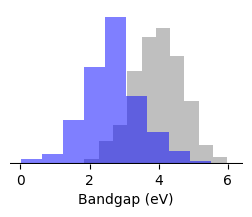

In [185]:
plt.figure(figsize=(3,2))
plt.hist(dream_results_df['seed_target'], bins=10, alpha=0.5, color='grey', label='seed', density=True)
plt.hist(dream_results_df['dreamed_target'], bins=10, alpha=0.5, color='blue', label='min', density=True)
plt.xlabel('Bandgap (eV)')
plt.box(False)
plt.tick_params(left=False, labelleft=False)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')

# plt.show()
plt.savefig('./bandgap_dream_distribution.png',dpi=300,bbox_inches='tight')

#### Comparing results before and after structural relaxation

To evaluate the impact that structural relaxation has on the predicted property values, we sampled a representative subset of 100 seed MOFs (and their optimised counterparts) and relaxed their crystal structures using the UFF forcefield as implemented in the Forcite Module of Materials Studio 2019. The results are shown below

In [168]:
# Note: these are the results obtained after reconstructing MOFs from their strings and using our in-house developed ML model to determine the high-fidelity properties
bandgap_min_relaxed = pd.read_csv('./dream_results/bandgap_min_100_dream_results_relaxed.csv')
bandgap_min_unrelaxed = pd.read_csv('./dream_results/bandgap_min_100_dream_results_unrelaxed.csv')

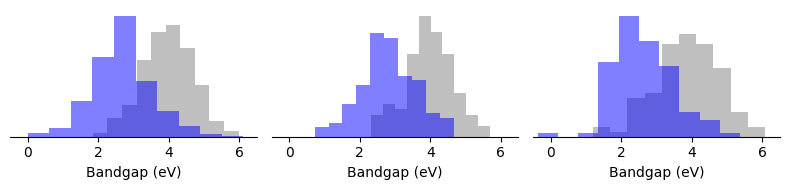

In [165]:
fig, ax = plt.subplots(1,3, figsize=(8, 2))

ax[0].hist(dream_results_df['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Original seed')
ax[0].hist(dream_results_df['dreamed_target'], bins=10, color='blue', alpha=0.5, density=True, label='Original dreamed')
# ax[0].set_title('Original Histograms')
ax[0].set_xlabel('Bandgap (eV)')
ax[0].set_xlim(-0.5,6.5)
# ax[0].legend(frameon=False)

ax[1].hist(bandgap_min_unrelaxed['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Sampled seed')
ax[1].hist(bandgap_min_unrelaxed['dreamed_target'], bins=10, color='blue', alpha=0.5, density=True, label='Sampled dreamed')
# ax[1].set_title('Sampled Histograms')
ax[1].set_xlabel('Bandgap (eV)')
ax[1].set_xlim(-0.5,6.5)
# ax[1].legend(frameon=False)

ax[2].hist(bandgap_min_relaxed['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Original seed')
ax[2].hist(bandgap_min_relaxed['dreamed_target'], bins=10, color='blue', alpha=0.5, density=True, label='Original dreamed')
# ax[2].set_title('Relaxed Histograms')
ax[2].set_xlabel('Bandgap (eV)')
ax[2].set_xlim(-0.5,6.5)

# ax[2].legend(frameon=False)

for a in ax:
    a.yaxis.set_ticks([])
    a.yaxis.set_ticklabels([])
    a.set_ylabel('')
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig('bandgap_relaxed_distributions.png',dpi=300,bbox_inches='tight')

Calculate the error for relaxed and unrelaxed KPIs

In [132]:
bandgap_min_relaxed['dreamed_mof_name'] = bandgap_min_relaxed['dreamed_mof_name'].str.replace('_opt', '')
bandgap_min_relaxed['seed_mof_name'] = bandgap_min_relaxed['seed_mof_name'].str.replace('_opt', '')

In [134]:
from sklearn.metrics import mean_absolute_error

merged_seed_df = pd.merge(bandgap_min_relaxed[['seed_mof_name','seed_target']], dream_results_df[['seed_mof_name','seed_target']], on='seed_mof_name',suffixes=('_relaxed', '_unrelaxed'))
merged_min_df = pd.merge(bandgap_min_relaxed[['dreamed_mof_name','dreamed_target']], dream_results_df[['dreamed_mof_name','dreamed_target']], on='dreamed_mof_name', suffixes=('_relaxed', '_unrelaxed'))

# calculcate MAE
print(
    mean_absolute_error(merged_seed_df['seed_target_relaxed'], merged_seed_df['seed_target_unrelaxed']),
    mean_absolute_error(merged_min_df['dreamed_target_relaxed'], merged_min_df['dreamed_target_unrelaxed']),
)

# Calculate Percentage Error
print(
    (((merged_seed_df['seed_target_relaxed'] - merged_seed_df['seed_target_unrelaxed']).abs() / merged_seed_df['seed_target_relaxed']) * 100).mean(),
    (((merged_min_df['dreamed_target_relaxed'] - merged_min_df['dreamed_target_unrelaxed']).abs() / merged_min_df['dreamed_target_relaxed']) * 100).mean(),
)

0.5870776762105263 0.7182007526879863
17.803225009709035 23.97050655348247
